# Neural Discrete Representation Learning

https://arxiv.org/pdf/1711.00937.pdf  
https://www.youtube.com/watch?v=tF1WSN-11PQ  
https://greeksharifa.github.io/discrete%20representation/2021/11/07/VQVAE/  
https://velog.io/@dien-eaststar/%EB%85%BC%EB%AC%B8-%EB%A6%AC%EB%B7%B0-SSL-Neural-Discrete-Representation-Learning  
https://process-mining.tistory.com/161  

supervision 없이 유용한 representation을 학습하는 것은 중요한 과제  
discrete representation을 학습하는 생성모델 Vector Quantised Variational AutoEncoder  
데이터를 압축하여 다른 모델과 함께 많이 쓰이는듯(DALLE 등등)


기존 VAE와 차이점
1. 기존 VAE와 달리 연속형 코드가 아닌 이산형 코드 반환
2. prior가 static하지 않고, 학습 가능함

Contribution :
1. VQ-VAE 소개 및 posterior collapse 우회
2. 기존 VAE에 못지않은 성능
3. powerful prior와 같이하면 다양한 범위에서 일관되고 높은 성능을 가질 수 있음
4. 지도없이 raw speech로부터 언어를 학습, speaker conversion 수행

## VAE ?

실제 데이터의 분포 $p_\theta(x)$ 의 loglikelihood 를 최대화 하는 것이 목표  

$ \log p_\theta(x) = \int q_ϕ(z|x)\log p_\theta(x) dz $  
$ \qquad\qquad = \int q_ϕ(z|x) \log \frac{p_\theta(x|z)p(z)}{p_\theta(z|x)} dz $  
$ \qquad\qquad = \int q_ϕ(z|x) \log \frac{p_\theta(x|z)p(z)}{p_\theta(z|x)} \frac{q_ϕ(z|x)}{q_ϕ(z|x)}dz $  
$ \qquad\qquad = \int q_ϕ(z|x) \log p_\theta(x|z)dz - \int q_ϕ(z|x) \log \frac{q_ϕ(z|x)}{p(z)}dz + \int q_ϕ(z|x) \log \frac{q_ϕ(z|x)}{p_\theta(z|x)}dz
 $  
$ \qquad\qquad = \mathbb{E}_{z \sim q_ϕ(z|x)}[\log p_\theta(x|z)] - D_{KL}(q_ϕ(z|x)||p(z)) + D_{KL}(q_ϕ(z|x)||p_\theta(z|x))$  
$ \qquad\qquad ≥ \mathbb{E}_{z \sim q_ϕ(z|x)}[\log p_\theta(x|z)] - D_{KL}(q_ϕ(z|x)||p(z)) $  

KL-Regulazation term으로 인한 posterior collapse!  




## VQ-VAE



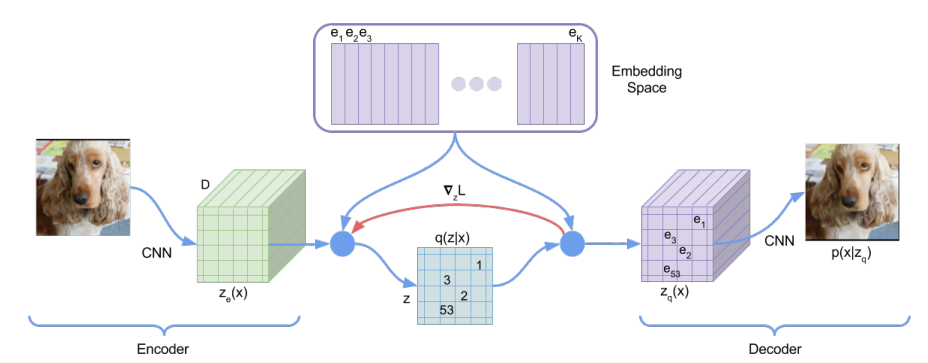

### Discrete latent variables  

$K$개의 $D$차원 embedding 을 가진 embedding space $e \in R^{K \times D}$ 를 정의  

input $x$는 인코더를 통해 $z_e(x)$로,  
input $x$의 posterior distribution 을 다음과 같이 정의하고,  
$ q(z=k|x) =  \begin{cases}
1 & \mbox{for }k=argmin_j||z_e(x)-e_j||_2 \\
0 & \mbox{otherwise} \end{cases} $ 를 통해 근접한 embedding으로 계산됨  

$q(z=k|x)$는 deterministic하고 uniform prior를 이용하므로써 KL divergence를 상수로 만듬  

$z_e(x)$는 아래의 매핑을 통해 디코더의 input으로 변환  
$z_q(x) = e_k, \space \mbox{where }\space k=argmin_j|| z_e(x)-e_j ||_2$


### Learning

forward 과정에서는 그림과 같이 nearest embedding 으로 디코더로 패스되고, backward 시 $\nabla_zL$를 드래도 인코더로 패스 (인코더의 output과 디코더의 input은 동일한 차원이고 gradient가 reconstruction loss를 줄이기 위한 인코딩을 하도록 유도)  

$ Loss = \log p(x|z_q(x)) +  || sg[z_e(x)]-e ||_2^2 + β|| z_e(x)-sg[e] ||_2^2$

1. reconstrcution loss > encoder, decoder
2. VQ obective > embedding 
 - gradient를 따로 받지 못하기 때문에
 - embedding vector e_i를 z_e(x)로 학습
3. commitment loss > embedding, encoder
 - embedding 차원으로 인해 e_i가 encoder의 parameter 처럼 빠르게 학습하지 못하고, 무작위로 upadate될 수 있음 > 이 문제 해결


### Prior

p(z)에 대한 prior 분포는 범주형 분포이며, feature map 안의 다른 z에 의해 autoregressive하게 만들어질수 있음  

training 중에는 prior는 uniform을 유지하다가 training이 끝나면 z, p(z)에 대한 autoregressive 분포를 fitting
 - for images > PixelCNN
 - for raw audio > WaveNet


## Experiments

### Comparison with continuous variables

| VAE | VQ-VAE | VIMCO |  
|---------------|----------------|----------------|
| 4.51 bits/dim | 4.67 bits/dim  | 5.14 bits/dim  |

### Images

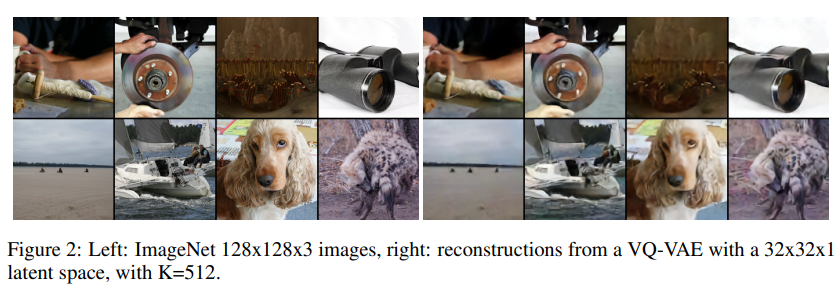

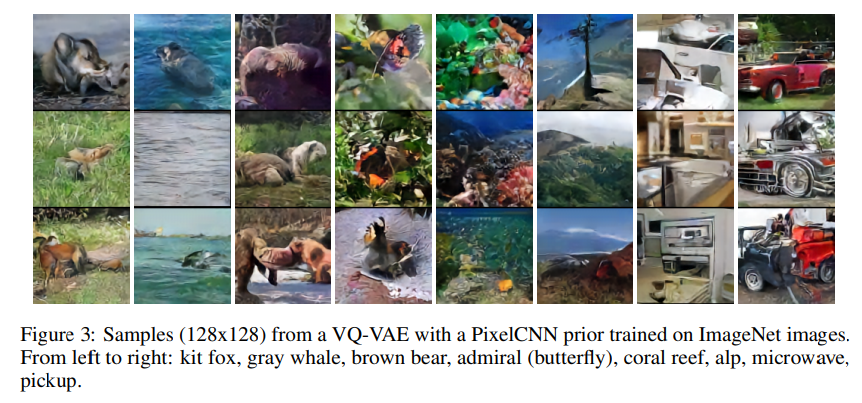

이외에도 audio, video에 관한 실험들 진행, 괜찮은 결과들

# 코드 실습

In [ ]:
# https://github.com/zalandoresearch/pytorch-vq-vae

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

import os
import glob
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# load dataset
x_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((64,64),
                      transforms.InterpolationMode("bicubic")),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])

os.chdir('/content/drive/MyDrive/Colab Notebooks')
celeba = datasets.ImageFolder('./Datasets/CelebA', transform=x_transform)

In [ ]:
# 너무 많은 양을 불러올땐 에러 발생 >> 위에 방법으로 하자

class dataset(torch.utils.data.Dataset):
  def __init__(self, path = './Datasets/CelebA/img_align_celeba'):
    super(dataset,self).__init__()
    self.files = sorted(glob.glob(path + "/*.jpg"))
  def __getitem__(self, index):
      img = Image.open(self.files[index % len(self.files)])
      img = x_transform(img)
      return img
  def __len__(self):
      return len(self.files)

celeba = dataset()

In [ ]:
class VectorQuantizer(nn.Module):
  def __init__(self, num_embed, embed_dim, commitment):
    super(VectorQuantizer, self).__init__()
    # embed_dim는 인코더의 hidden_size 논문에서 D
    self.embed_dim = embed_dim
    # num_embed는 논문에서 K
    self.num_embed = num_embed
    self.embedding = nn.Embedding(self.num_embed, self.embed_dim)
    self.embedding.weight.data.uniform_(-1/self.num_embed, 1/self.num_embed)
    self.commitment = commitment

  def forward(self, inputs):
    # convert inputs from B,C,H,W >> B,H,W,C
    # https://sanghyu.tistory.com/3 참고하자
    inputs = inputs.permute(0, 2, 3, 1).contiguous()
    input_shape = inputs.shape
    
    # Flatten input B,H,W,C >> B*H*W , C
    flat_input = inputs.view(-1, self.embed_dim)
    
    # Calculate distances
    distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                + torch.sum(self.embedding.weight**2, dim=1)
                - 2 * torch.matmul(flat_input, self.embedding.weight.t()))
        
    # Encoding
    encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
    encodings = torch.zeros(encoding_indices.shape[0], self.num_embed, device=inputs.device)
    encodings.scatter_(dim=1, index=encoding_indices, src=torch.ones_like(encodings))
    
    # Quantize and unflatten
    quantized = torch.matmul(encodings, self.embedding.weight).view(input_shape)
    
    # Loss
    e_latent_loss = F.mse_loss(quantized.detach(), inputs)
    q_latent_loss = F.mse_loss(quantized, inputs.detach())
    loss = q_latent_loss + self.commitment * e_latent_loss
    
    quantized = inputs + (quantized - inputs).detach()
    avg_probs = torch.mean(encodings, dim=0)
    perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
    
    # convert quantized from B,H,W,C >> B,C,H,W
    return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encodings


In [ ]:
class Block(nn.Module):
  def __init__(self, in_channel, hidden_size, block_hidden):
    super(Block, self).__init__()
    self.block = nn.Sequential(
        nn.Conv2d(in_channel, block_hidden, 3, 1, 1),
        nn.ReLU(True),
        nn.Conv2d(block_hidden, hidden_size, 1, 1, 0),
        nn.ReLU(True)
    )
  
  def forward(self, x):
    # skip-connection
    return x + self.block(x)

class Residual(nn.Module):
  def __init__(self, in_channel, hidden_size, block_hidden, num_layers):
    super(Residual, self).__init__()
    self.layers = nn.ModuleList([Block(in_channel, hidden_size, block_hidden)
                                  for _ in range(num_layers)])
  def forward(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

In [ ]:
class Encoder(nn.Module):
  def __init__(self, hidden_size, block_hidden, num_layers):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(3, hidden_size//2, 4, 2, 1)
    self.conv2 = nn.Conv2d(hidden_size//2, hidden_size, 4, 2, 1)
    self.conv3 = nn.Conv2d(hidden_size, hidden_size, 3, 1, 1)
    self.residual = Residual(in_channel = hidden_size,
                             hidden_size = hidden_size,
                             block_hidden = block_hidden,
                             num_layers = num_layers)
  def forward(self, x):
    # 3 x 64 x 64
    x = self.conv1(x)
    x = F.relu(x)
    # h//2 x 32 x 32
    x = self.conv2(x)
    x = F.relu(x)
    # h x 16 x 16
    x = self.conv3(x)
    x = F.relu(x)
    # h x 16 x 16
    return self.residual(x) # h x 16 x 16

In [ ]:
class Decoder(nn.Module):
  def __init__(self, hidden_size, block_hidden, num_layers):
    super(Decoder, self).__init__() 
    self.residual = Residual(in_channel = hidden_size,
                             hidden_size = hidden_size,
                             block_hidden = block_hidden,
                             num_layers = num_layers)
    self.cont1 = nn.ConvTranspose2d(hidden_size, hidden_size, 3, 1, 1)
    self.cont2 = nn.ConvTranspose2d(hidden_size, hidden_size//2, 4, 2, 1)
    self.cont3 = nn.ConvTranspose2d(hidden_size//2, 3, 4, 2, 1) 

  def forward(self, x):
    # h x 16 x 16
    x = self.residual(x)
    # h x 16 x 16
    x = self.cont1(x)
    x = F.relu(x)
    # h x 16 x 16
    x = self.cont2(x)
    x = F.relu(x)
    # h//2 x 32 x 32
    x = self.cont3(x)
    return torch.tanh(x) # 3 x 64 x 64    

In [ ]:
class VQ_VAE(nn.Module):
  def __init__(self, hidden_size, block_hidden, num_layers,
               num_embed, embed_dim, commitment):
    super(VQ_VAE, self).__init__()
    self.encoder = Encoder(hidden_size, block_hidden, num_layers)
    self.vq = VectorQuantizer(num_embed, embed_dim, commitment)
    self.decoder = Decoder(hidden_size, block_hidden, num_layers)

  def forward(self, x):
    z = self.encoder(x)
    loss, quantized, perplexity, _ = self.vq(z)
    x_re = self.decoder(quantized)
    return loss, x_re, perplexity

In [ ]:
# parameter

D = 64
K = 512
num_layers = 2
block_hidden = 32
commitment = 0.25
data_variance = 1

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VQ_VAE(hidden_size = D,
               block_hidden = block_hidden,
               num_layers = num_layers,
               num_embed = K,
               embed_dim = D,
               commitment = commitment).to(device)
               

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9,0.999))

In [ ]:
train_loader = torch.utils.data.DataLoader(celeba, batch_size=128, shuffle=True)

In [ ]:
model.load_state_dict(torch.load('/content/vq_vae_60'))

<All keys matched successfully>

In [ ]:
X = next(iter(train_loader))

In [ ]:
X = X[0]
grid_real = make_grid(X[:100],nrow=10, normalize=True)

In [ ]:
X = X.to(device)
X_h = model(X)

In [ ]:
grid_reco = make_grid(X_h[1][:100],nrow=10, normalize=True)

In [ ]:

grid_reco = make_grid(X_h[:100],nrow=10, normalize=True)

In [ ]:
grid = torch.concat([grid.to(device), grid_reco], dim=1)

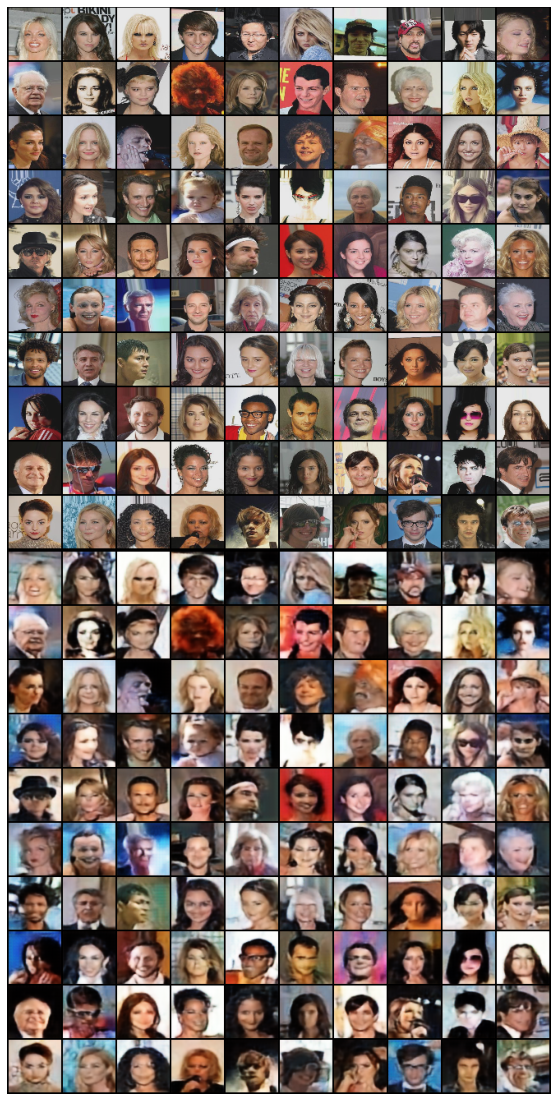

In [ ]:
plt.figure(figsize=(10,20))
plt.axis('off')
plt.imshow(np.transpose(grid.detach().cpu(), (1,2,0)))

In [ ]:
# training

# start_epoch = 0
# # model.load_state_dict(torch.load('./코드 이론/model_save/VQVAE_CelebA/vq_vae_%d'%start_epoch))

# for epoch in range(start_epoch, start_epoch+51):
#   model.train()
#   s_loss, s_per = 0, 0
#   for i, (img, _) in enumerate(train_loader):
#     img = img.to(device)

#     optimizer.zero_grad()
#     vq_loss, x_re, perplexity = model(img)
#     # normalize the reconstruction loss with respect to the scale of the input data
#     # 아직 못구함 구해야함 일단 해보자
#     recon_loss = F.mse_loss(x_re, img) / data_variance
#     loss = vq_loss + recon_loss
#     loss.backward()
#     optimizer.step()

#     s_loss += loss.item()
#     s_per += perplexity.item()
    
#   # every epoch
#   print('[Epoch %3d] [loss %.4f] [perplexity %.2f]'%
#             (epoch+1, s_loss/len(train_loader), 
#              s_per/len(train_loader)))
  
#   if (epoch)%1==0:
#     torch.save(model.state_dict(),'./코드 이론/model_save/VQVAE_CelebA/vq_vae_%d'%epoch)